<a href="https://colab.research.google.com/github/plaban1981/BERT-NLP/blob/master/Firstai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.text import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
train = pd.read_csv('/content/drive/My Drive/Zindi/Tech4MentalHealth/Train.csv')
test = pd.read_csv('/content/drive/My Drive/Zindi/Tech4MentalHealth/Test.csv')

In [5]:
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [7]:
label_encoded = pd.get_dummies(train['label'])

In [8]:
train = pd.concat([train,label_encoded],axis=1)

In [9]:
train.head()

,ID,text,label,Alcohol,Depression,Drugs,Suicide
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,0,1,0,0
1,9JDAGUV3,Why do I get hallucinations?,Drugs,0,0,1,0
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,0,1,0,0
3,6UY7DX6Q,Why is life important?,Suicide,0,0,0,1
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,0,1,0,0


In [10]:
train.columns

Index(['ID', 'text', 'label', 'Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype='object')

In [11]:
train_data = train[['text', 'Alcohol', 'Depression', 'Drugs', 'Suicide']]

In [12]:
train_data.head()

,text,Alcohol,Depression,Drugs,Suicide
0,I feel that it was better I dieAm happy,0,1,0,0
1,Why do I get hallucinations?,0,0,1,0
2,I am stresseed due to lack of financial suppor...,0,1,0,0
3,Why is life important?,0,0,0,1
4,How could I be helped to go through the depres...,0,1,0,0


In [13]:
# Remove punctuation or symbol from the text data
train_data['text'] = train_data['text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')
test['text'] = test['text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
train_data.head()

,text,Alcohol,Depression,Drugs,Suicide
0,I feel that it was better I dieAm happy,0,1,0,0
1,Why do I get hallucinations?,0,0,1,0
2,I am stresseed due to lack of financial suppor...,0,1,0,0
3,Why is life important?,0,0,0,1
4,How could I be helped to go through the depres...,0,1,0,0


In [20]:
# Create databunch
data = (TextList.from_df(train_data, cols='text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=16))
data.show_batch()

idx,text
0,"xxunk sad , alone and always on xxunk i know how to cope with xxunk xxunk in my life xxbos i feel xxunk , xxunk xxunk xxbos i experienced depression in my xxunk xxbos i feel like am alone in this world xxbos i feel low and out of place xxbos i feel hopeless , unworthy and xxunk … xxmaj how do i cope with stress and xxunk the past"
1,"xxbos xxmaj what to do to xxunk the bad feeling ? xxbos xxmaj too much xxunk , and how do i cope xxunk many xxunk xxbos xxmaj how can i stop alcohol xxbos i am xxunk a lot of challenges in life financially , emotionally , xxunk and with no solutions … xxmaj how can i xxunk xxunk for solutions about depression on xxunk xxbos i always feel down xxbos"
2,"xxbos should i stop drinking alcohol xxbos i feel so xxunk , why does this xxunk ? xxbos xxmaj what is the best way to xxunk from drugs ? xxbos xxmaj feelings of xxunk and xxunk and feelings of xxunk xxbos xxmaj what is a good of life ? xxbos xxmaj what are the effects of depression ? xxbos xxmaj xxunk to take to overcome suicidal thoughts xxbos how do"
3,"xxunk my money on alcohol with friends xxbos xxmaj xxunk xxbos xxmaj how does one come out of depression ? xxbos xxmaj how to stop the addiction xxbos i am xxmaj lonely and xxunk myself , xxunk because of relationship issues xxbos i 'm still depressed and xxunk of my xxunk health xxbos xxmaj how will i stop ? xxbos xxmaj what can one do to reduce the feeling of"
4,i feel xxunk okay xxbos i feel low and lost xxunk in xxunk feel better now xxbos i have a xxunk that xxunk all xxunk from my family xxbos i am xxunk in a xxmaj xxunk xxunk and i would like to know xxunk can i control myself ? xxbos i xxunk money on alcohol xxbos xxmaj what are the effects of smoking bhang ? xxbos xxmaj what are the


# Fit the deep learning model with domain specific data

First, we will fit our model with train data without target values so that our model knows better about our data.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


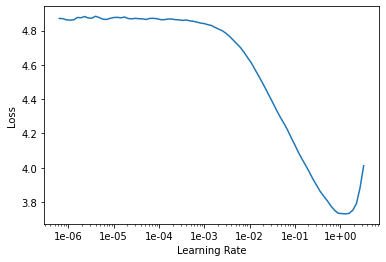

In [21]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

In [22]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.277686,3.096853,0.289286,00:00
1,3.538177,2.791060,0.342857,00:00
2,3.120265,2.627757,0.359821,00:00
3,2.803739,2.577554,0.380357,00:00
4,2.568672,2.559088,0.378571,00:00


# Re-fit model with classification label

In [23]:
test = test[['text']]

In [24]:
label_cols = ['Alcohol', 'Depression', 'Drugs', 'Suicide']

test_datalist = TextList.from_df(test, cols='text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos i am financially xxunk over school xxunk and my family xxunk is not xxunk with a lot of xxunk … i have an xxunk xxunk who could xxunk xxunk me but xxunk no xxunk even after xxunk,Depression
"xxbos i am xxunk a lot of challenges in life financially , emotionally , xxunk and with no solutions … xxmaj how can i xxunk xxunk for solutions about depression on xxunk",Depression
"xxbos i feel like the world was against me , xxunk from friends and xxunk who were close to me i xxunk it that my life is more xxunk",Depression
xxbos xxmaj what can i do to avoid loss of xxunk in xxunk through xxunk in xxunk and xxunk times xxunk on xxunk and xxunk issues,Depression
"xxbos xxmaj why do people take alcohol and how xxunk is it to xxunk life , xxmaj what should one do to avoid taking alcohol",Alcohol


epoch,train_loss,valid_loss,time
0,0.728084,#na#,00:00
1,0.731500,#na#,00:00
2,0.727431,#na#,00:00
3,0.697828,#na#,00:00
4,0.624703,#na#,00:00
5,0.638426,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.558213,0.370878,00:00
1,0.476429,0.389133,00:00
2,0.433930,0.406426,00:00
3,0.405328,0.328577,00:00
4,0.380209,0.327843,00:00


text,target,prediction
"xxbos xxmaj at xxunk , no one xxunk to me , my parents xxunk xxunk and xxunk me , what can i do ?",Depression,Depression
xxbos i am experiencing a xxunk in xxunk my school xxunk and it was not an xxunk xxunk because of the family issues,Depression,Depression
xxbos i am xxunk in a xxmaj xxunk xxunk and i would like to know xxunk can i control myself ?,Depression,Depression
xxbos i do xxunk depression at times and i think the best way to avoid it is xxunk myself xxunk,Depression,Depression
xxbos xxmaj it xxunk as if my xxunk is xxunk xxmaj xxunk of xxunk xxmaj am feeling much better,Depression,Depression


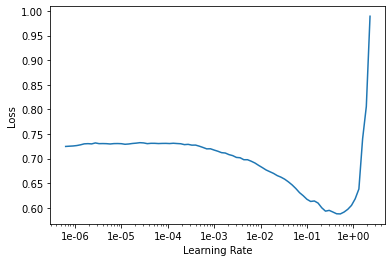

In [25]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()

# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

learn_classifier.show_results()

In [27]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()



labels

array([[0.171384, 0.654426, 0.010794, 0.290998],
       [0.006985, 0.984571, 0.001019, 0.00206 ],
       [0.022031, 0.941499, 0.012788, 0.058216],
       [0.028934, 0.92871 , 0.012131, 0.053385],
       ...,
       [0.046668, 0.95757 , 0.014122, 0.016104],
       [0.182849, 0.52896 , 0.078864, 0.158188],
       [0.184406, 0.473353, 0.204253, 0.03405 ],
       [0.161224, 0.775965, 0.025315, 0.02626 ]], dtype=float32)

In [28]:
labels.shape

(309, 4)

In [30]:
submission = pd.concat([test,pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission.csv', index=False)
submission.head()

,ID,text,Alcohol,Depression,Drugs,Suicide
0,02V56KMO,How to overcome bad feelings and emotions,0.171384,0.654426,0.010794,0.290998
1,03BMGTOK,I feel like giving up in life,0.006985,0.984571,0.001019,0.002060
2,03LZVFM6,I was so depressed feel like got no strength t...,0.022031,0.941499,0.012788,0.058216
3,0EPULUM5,I feel so low especially since I had no one to...,0.028934,0.928710,0.012131,0.053385
4,0GM4C5GD,can i be successful when I am a drug addict?,0.112417,0.607146,0.112817,0.129334


In [31]:
submission.tail(25)

,ID,text,Alcohol,Depression,Drugs,Suicide
284,X2E196ZE,"How to completely stop using alcohol, -possibl...",0.087702,0.413501,0.039381,0.333901
285,X72WL59G,I feel like I want to end my life,0.008309,0.994654,0.000117,0.002349
286,XDK01LYR,I am anxious of what is going to happen in the...,0.107342,0.906286,0.011083,0.075783
287,XLE74IX1,Can the habit be stopped at once?,0.166374,0.591103,0.128671,0.064896
288,XU4HGW9C,How can I stop drinking?,0.641919,0.189782,0.121704,0.018256
289,XUHRT8P4,I don't see the need to live in the world,0.047580,0.869485,0.011660,0.084254
290,XXMTEUX8,How do I go about solving my problem?,0.149255,0.680091,0.059735,0.093370
291,XYRTMPGC,I feel depressed because of lack of school fee...,0.110609,0.560192,0.037806,0.302899
292,Y3QTMIO7,Dumped with my boyfriend?,0.053156,0.899314,0.020745,0.018219
293,Y5S49JQ7,Asked for financial support from wellwishers,0.016261,0.952796,0.001504,0.017024


In [32]:
submission = submission[['ID','Depression','Alcohol','Suicide','Drugs']]

In [33]:
submission.tail(25)

,ID,Depression,Alcohol,Suicide,Drugs
284,X2E196ZE,0.413501,0.087702,0.333901,0.039381
285,X72WL59G,0.994654,0.008309,0.002349,0.000117
286,XDK01LYR,0.906286,0.107342,0.075783,0.011083
287,XLE74IX1,0.591103,0.166374,0.064896,0.128671
288,XU4HGW9C,0.189782,0.641919,0.018256,0.121704
289,XUHRT8P4,0.869485,0.047580,0.084254,0.011660
290,XXMTEUX8,0.680091,0.149255,0.093370,0.059735
291,XYRTMPGC,0.560192,0.110609,0.302899,0.037806
292,Y3QTMIO7,0.899314,0.053156,0.018219,0.020745
293,Y5S49JQ7,0.952796,0.016261,0.017024,0.001504


In [34]:
submission.to_csv('submission.csv', index=False)